### Bulk to single-cell decomposition

Here we explore how we can assemble single-cells to form pseudo-bulk as close as possible to our reference bulk samples.

In [2]:
# Load general Libraries
library(Matrix) ; library(ggplot2) ; library(glmnet)
library(RColorBrewer) ; library(dplyr) ; library(Biobase)
library(IRdisplay) ; library(reshape2) ; library(ggpubr)
library(xbioc) ; library(ComplexHeatmap)
library(SingleCellExperiment) ;  library(ggpmisc)
library(circlize) ; library(MASS)
library(dampack) ; library(rBeta2009) # dampack-rBeta2009 package need to use Dirichlet distribution modelling
# deconvolution methods 
library(MuSiC) ; library(BayesPrism); library(BisqueRNA)
library(climb)

In [117]:
#detach("package:climb", unload=TRUE)
#devtools::install_github('alexdray86/climb', force=T)
#library(climb)

### Important functions

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = F, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_climb_dw <- function(sc, bulks, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = T, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="state")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
write_tables_tape_scaden <- function(sc, bulks, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  '../REVISION_1/data/celltype_expression/TAPE/input/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')
    climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='X')
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    return(all_p)
}                                                                                           

launch_deconvolution_cohort <- function(sc, bulks, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    write.csv(celltype_names, paste0(out_dir, '/celltype_names.csv'), quote=F)

    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    
    ### CLIMB deconvolution ###
    message('CLIMB-DW deconvolution')
    climb_dw_prop = deconvolution_climb_dw(sc, bulks, celltype_names)
    write.csv(climb_dw_prop, paste0(out_dir, '/climb_dw_prop.csv'), quote=F)
    
    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    
    ### CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, celltype_names, tmp_dir)
}   

In [4]:
# '../REVISION_1/data/vangalen_scrna/cancer_cell_type_signature.csv'
compute_vangalen_signature <- function(file_signature, b.es){
    ct_signatures = read.csv(file_signature)
    celltypes = c('HSC-like', 'Prog-like', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')
    colnames(ct_signatures) <- celltypes
    bulk_cpm = t(1e6*(t(exprs(b.es)) / colSums(exprs(b.es))))
    bulk_cpm_scale = t(scale(t(bulk_cpm)))
    signature_scores_l = list() ; signature_scores_l.bma = list()
    for(k in 1:length(celltypes)){
        celltype = colnames(ct_signatures)[k]
        sel.sign = rownames(bulk_cpm_scale) %in% ct_signatures[,k]
        sign = colMeans(bulk_cpm_scale[sel.sign,])
        signature_scores_l[[k]] = num(sign)
    }
    return(signature_scores_l)
}

In [5]:
vangalen_sign_file = '../REVISION_1/data/vangalen_scrna/cancer_cell_type_signature.csv'

## Load reference scRNA-seq data

In [116]:
sc.es = readRDS("data/pseudobulks_climb/AML_vangalen_sc_es_2.RDS")
sc.es$cellType = factor(reformat_celltypes(sc.es$cellType))
celltype_names = reformat_celltypes(levels(sc.es$cellType))

## Launch Deconvolution panel on BeatAML cohort

We use Van Galen as a reference single-cell RNA-seq as it was not purified was FACS and should contain more even cell subtype proportions than Naldini's dataset.

In [108]:
# Load BeatAML bulk samples
bulk.es = readRDS("data/aml_3cohorts/beatAML_bulk_es_451s.RDS")

In [107]:
# Run CLIMB, WARNING: takes around 6 hours
#climb_out.beataml = climb(sc = sc.es2, bulk = bulk.es, mode='abundance')

In [109]:
vangalen.beataml = compute_vangalen_signature(vangalen_sign_file, bulk.es)

In [112]:
all(colnames(bulk.es) == rownames(lsc17.beataml))

[1] TRUE

In [114]:
out_dir = 'data/aml_3cohorts/beat_aml_deconvolution2'
# Run Deconvolution Panel, WARNING: takes around 24 hours
#launch_deconvolution_cohort(sc = sc.es, bulks = bulk.es, celltype_names = celltype_names, out_dir=out_dir)

In [6]:
all_props.beataml = load_all_props('data/aml_3cohorts/beat_aml_deconvolution', include_cibersortx = F)

In [7]:
climb_out.beataml = all_props.beataml$`CLIMB-DW`

## Launch Deconvolution on TCGA cohort

In [132]:
bulk.es = readRDS('../REVISION_1/data/tcga/TCGA_AML_bulk_es.RDS')

In [133]:
bulk_cpm = t(1e6*(t(exprs(bulk.es)) / colSums(exprs(bulk.es))))

In [134]:
exprs(bulk.es) = bulk_cpm

In [136]:
# Run CLIMB, WARNING: takes around 3/4 hours
# climb_out.tcga = climb(sc = sc.es2, bulk = bulk.es, mode='abundance')

In [137]:
vangalen.tcga = compute_vangalen_signature(vangalen_sign_file, bulk.es)

In [138]:
metadata.tcga = pData(bulk.es)

In [139]:
out_dir = 'data/aml_3cohorts/tcga_aml_deconvolution2'
# Run Deconvolution Panel, WARNING: takes around 24 hours
# launch_deconvolution_cohort(sc = sc.es, bulks = bulk.es, celltype_names = celltype_names, out_dir=out_dir)

In [9]:
all_props.tcga = load_all_props('data/aml_3cohorts/tcga_aml_deconvolution', include_cibersortx = F)

In [145]:
lsc17.tcga = read.csv('data/aml_3cohorts/TCGA_AML_lsc17.csv',row.names='sample_name')
all(rownames(lsc17.tcga) == colnames(bulk.es))

[1] TRUE

In [146]:
cor(lsc17.tcga$LSC17_score, all_props.tcga$`CLIMB-DW`[,'HSClike'])

[1] 0.2184658

In [102]:
this_celltype = 'HSClike'
methods = names(all_props.tcga)
gmp_results = list()
for(m in 1:length(methods)){
    this_prop = all_props.tcga[[m]]
    this_method = methods[m]
    df_gmp = data.frame(ery_score = signature_scores[,this_celltype] / max(signature_scores[,this_celltype]), 
                        props = num(rowSums(this_prop[,grepl('Ery', colnames(this_prop))])))#this_prop[,this_celltype])
    df_gmp$group1 = ifelse(tcga_metadata$FAB == 'M0', 'M0', 'other class')
    df_gmp$group2 = ifelse(tcga_metadata$FAB == 'M0', 'M0', 'other class')
    df_gmp$method = this_method
    gmp_results[[m]] = df_gmp
}
df_gmp_results = do.call(rbind, gmp_results)
df_gmp_results$dataset = 'TCGA-AML'

ERROR: Error in data.frame(ery_score = signature_scores[, this_celltype]/max(signature_scores[, : object 'signature_scores' not found


## Launch Deconvolution on Leucegene cohort

In [154]:
bulk.es = readRDS("data/aml_3cohorts/leucegene_bulk_all_es.RDS")

In [155]:
climb_out.leucegene = climb(sc = sc.es2, bulk = bulk.es, norm_coefs = F, dwls_weights = T, mode='abundance')

ABUNDANCE mode: predicting cell-type proportions in bulks

9432 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 



In [77]:
vangalen.leucegene = compute_vangalen_signature(vangalen_sign_file, bulk.es)

In [37]:
out_dir = 'data/aml_3cohorts/leucegene_aml_deconvolution2'
launch_deconvolution_cohort(sc = sc.es, bulks = bulk.es, celltype_names = celltype_names, out_dir=out_dir)

Creating folders

CLIMB deconvolution

ABUNDANCE mode: predicting cell-type proportions in bulks

9544 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 

CLIMB-DW deconvolution

ABUNDANCE mode: predicting cell-type proportions in bulks

9544 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 

BayesPrism deconvolution



number of cells in each cell state 
cell.state.labels
       ProB     lateEry         CTL     ProMono    earlyEry      Plasma 
         55         172         173         180         213         215 
        cDC         GMP         HSC          NK        Prog        Mono 
        221         242         266         322         326         600 
          T ProMonolike     HSClike     GMPlike     cDClike    Monolike 
        682        1387        1436        1719        1942        2403 
   Proglike 
       2701 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 9 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-07-04 12:00:34 
Estimated time to complete:  5hrs 5mins 
Estimated finishing time:  2023-07-04 17:05:08 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-07-04 14:31:26 
Estimated time to complete:  4hrs 27mins 
Estimated finishing time:  2023-07-04 18:58:24 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster


Warning message in get.fraction(bp = bp.res, which.theta = "final", state.or.type = "state"):
“Warning: only cell type is available for updated Gibbs. Returning cell type info.”
MUSIC deconvolution

NNLS deconvolution

BisqueRNA deconvolution

Decomposing into 19 cell types.

Using 9544 genes in both bulk and single-cell expression.

Converting single-cell counts to CPM and filtering zero variance genes.

Filtered 0 zero variance genes.

Converting bulk counts to CPM and filtering unexpressed genes.

Filtered 16 unexpressed genes.

Generating single-cell based reference from 15255 cells.


Inferring bulk transformation from single-cell alone.

Applying transformation to bulk samples and decomposing.

TAPE / Scaden deconvolution

Launch Scaden / TAPE deconvolution

Random deconvolution

Writing tables for CiberSortX



In [10]:
all_props.leucegene = load_all_props('data/aml_3cohorts/leucegene_aml_deconvolution2', include_cibersortx = F)

In [39]:
bulk.mtx.t = log2(data.frame(t(exprs(bulk.es)))+1)
lsc17.leucegene = (bulk.mtx.t$DNMT3B * 0.0874) + (bulk.mtx.t$ZBTB46 * -0.0347) + 
    (bulk.mtx.t$NYNRIN * 0.00865) + (bulk.mtx.t$ARHGAP22 * -0.0138) + 
    (bulk.mtx.t$LAPTM4B * 0.00582) + (bulk.mtx.t$MMRN1 * 0.0258) + (bulk.mtx.t$DPYSL3 * 0.0284) + 
    (bulk.mtx.t$KIAA0125 * 0.0196) + (bulk.mtx.t$CDK6 * -0.0704) + (bulk.mtx.t$CPXM1 * -0.0258) + 
    (bulk.mtx.t$SOCS2 * 0.0271) + (bulk.mtx.t$C19orf77 * -0.0226) + (bulk.mtx.t$EMP1 * 0.0146) + 
    (bulk.mtx.t$NGFRAP1 * 0.0465) + (bulk.mtx.t$CD34 * 0.0338) + (bulk.mtx.t$AKR1C3 * -0.0402) + (bulk.mtx.t$GPR56 * 0.0501)

In [165]:
cor(climb_out.leucegene$props[,'HSC-like'], lsc17.leucegene)

[1] 0.3102917

In [106]:
mat_cor_lsc17 = cbind(cor(rbind(all_props.beataml$`CLIMB-DW`[,celltype_names], all_props.tcga$`CLIMB-DW`[,celltype_names], all_props.leucegene$`CLIMB-DW`[,celltype_names]), 
          c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$Scaden[,celltype_names], all_props.tcga$Scaden[,celltype_names], all_props.leucegene$Scaden[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$TAPE[,celltype_names], all_props.tcga$TAPE[,celltype_names], all_props.leucegene$TAPE[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$MuSiC[,celltype_names], all_props.tcga$MuSiC[,celltype_names], all_props.leucegene$MuSiC[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$NNLS[,celltype_names], all_props.tcga$NNLS[,celltype_names], all_props.leucegene$NNLS[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$BayesPrism[,celltype_names], all_props.tcga$BayesPrism[,celltype_names], all_props.leucegene$BayesPrism[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$BisqueRNA[,celltype_names], all_props.tcga$BisqueRNA[,celltype_names], all_props.leucegene$BisqueRNA[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ),
      cor(rbind(all_props.beataml$Random[,celltype_names], all_props.tcga$Random[,celltype_names], all_props.leucegene$Random[,celltype_names]), 
    c(lsc17.beataml$LSC17_score, lsc17.tcga$LSC17_score, lsc17.leucegene) ))
colnames(mat_cor_lsc17) = c('CLIMB', 'Scaden', 'TAPE', 'MuSiC', 'NNLS', 'BayesPrism', 'BisqueRNA', 'Random')

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'cor': object 'celltype_names' not found


In [235]:
df_cor_lsc17 = data.frame(celltype=rownames(mat_cor_lsc17), climb=mat_cor_lsc17[,'CLIMB'], scaden=mat_cor_lsc17[,'Scaden'])
df_cor_lsc17$celltype = gsub('like', '-like',df_cor_lsc17$celltype)


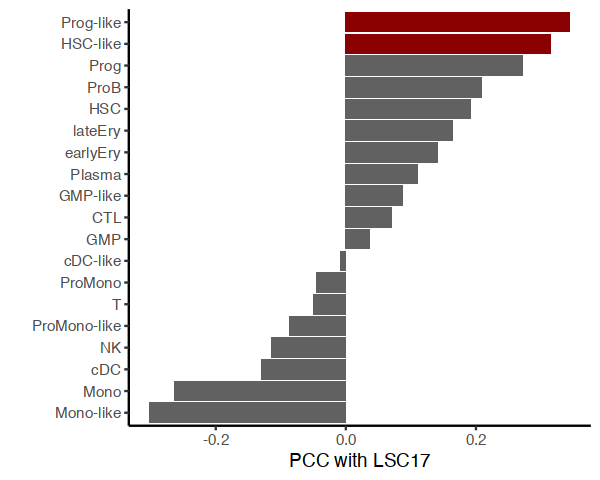

In [237]:
options(repr.plot.width=5, repr.plot.height=4)
df_cor_lsc17$celltype = factor(df_cor_lsc17$celltype, levels=df_cor_lsc17$celltype[order(df_cor_lsc17$climb)])
ggplot(df_cor_lsc17) + geom_bar(aes(y=celltype, x=climb, fill=celltype), stat = 'identity') + 
xlab('PCC with LSC17') + ylab('') + 
scale_fill_manual(values=ifelse(grepl('HSC-like|Prog-like', df_cor_lsc17$celltype[order(df_cor_lsc17$climb)]), 'darkred', 'grey38'), guide='none') +
theme_classic() 

In [223]:
ifelse(grepl('HSClike', df_cor_lsc17$celltype), 'darkred', 'grey38')

[1] "grey38"  "grey38"  "grey38"  "grey38"  "darkred" "grey38"  "grey38" 
 [8] "grey38"  "grey38"  "grey38"  "grey38"  "grey38"  "grey38"  "grey38" 
[15] "grey38"  "grey38"  "grey38"  "grey38"  "grey38"

### Look at HSC-like signature from Van Galen 

In [55]:
ct_signatures = read.csv('../REVISION_1/data/vangalen_scrna/cancer_cell_type_signature.csv')
celltypes = c('HSC-like', 'Prog-like', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')
colnames(ct_signatures) <- celltypes
bulk_cpm = t(1e6*(t(exprs(bulk.es)) / colSums(exprs(bulk.es))))
bulk_cpm_scale = t(scale(t(bulk_cpm)))
signature_scores_l = list() ; signature_scores_l.bma = list()
for(k in 1:length(celltypes)){
    celltype = colnames(ct_signatures)[k]
    sel.sign = rownames(bulk_cpm_scale) %in% ct_signatures[,k]
    sign = colMeans(bulk_cpm_scale[sel.sign,])
    signature_scores_l[[k]] = num(sign)
}

In [83]:
vg.hsclike.sign = unlist(c(vangalen.beataml[[1]], vangalen.tcga[[1]], vangalen.leucegene[[1]]))

In [239]:
vgsign_cor = c(cor(vg.hsclike.sign, c(num(all_props.beataml$`CLIMB-DW`[,'HSClike']), num(all_props.tcga$`CLIMB-DW`[,'HSClike']), num(all_props.leucegene$`CLIMB-DW`[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$Scaden[,'HSClike']), num(all_props.tcga$Scaden[,'HSClike']), num(all_props.leucegene$Scaden[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$TAPE[,'HSClike']), num(all_props.tcga$TAPE[,'HSClike']), num(all_props.leucegene$TAPE[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$BayesPrism[,'HSClike']), num(all_props.tcga$BayesPrism[,'HSClike']), num(all_props.leucegene$BayesPrism[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$MuSiC[,'HSClike']), num(all_props.tcga$MuSiC[,'HSClike']), num(all_props.leucegene$MuSiC[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$NNLS[,'HSClike']), num(all_props.tcga$NNLS[,'HSClike']), num(all_props.leucegene$NNLS[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$BisqueRNA[,'HSClike']), num(all_props.tcga$BisqueRNA[,'HSClike']), num(all_props.leucegene$BisqueRNA[,'HSClike']))),
cor(vg.hsclike.sign, c(num(all_props.beataml$Random[,'HSClike']), num(all_props.tcga$Random[,'HSClike']), num(all_props.leucegene$Random[,'HSClike']))))
names(vgsign_cor) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')

## Draw heatmap with all props from 3 datasets

In [11]:
climb_beataml = all_props.beataml$`CLIMB-DW`
climb_tcga = all_props.tcga$`CLIMB-DW`
climb_leucegene = all_props.leucegene$`CLIMB-DW`
all(colnames(climb_beataml) == colnames(climb_tcga))
all(colnames(climb_beataml) == colnames(climb_leucegene))

[1] TRUE

[1] TRUE

In [12]:
rownames(climb_leucegene) = gsub('X','',rownames(climb_leucegene))
climb_3datasets = rbind(climb_tcga, climb_leucegene, climb_beataml)
metadata = read.csv('data/aml_3cohorts/merge_metadata.csv', row.names='X')
all(rownames(climb_3datasets) == rownames(metadata))
metadata$sample_name = rownames(metadata)
FAB_onehot = dcast(data = metadata, sample_name ~ FAB, length)
FAB_onehot = FAB_onehot[match(rownames(metadata), FAB_onehot$sample_name),]

[1] TRUE

Using sample_name as value column: use value.var to override.



In [18]:
bma.selection = metadata$tissue_type == 'Bone Marrow Aspirate'

In [22]:
# Subset bone marrow samples
climb_3datasets = climb_3datasets[bma.selection,]
metadata = metadata[bma.selection,]
FAB_onehot = FAB_onehot[bma.selection,]

pdf 
  2

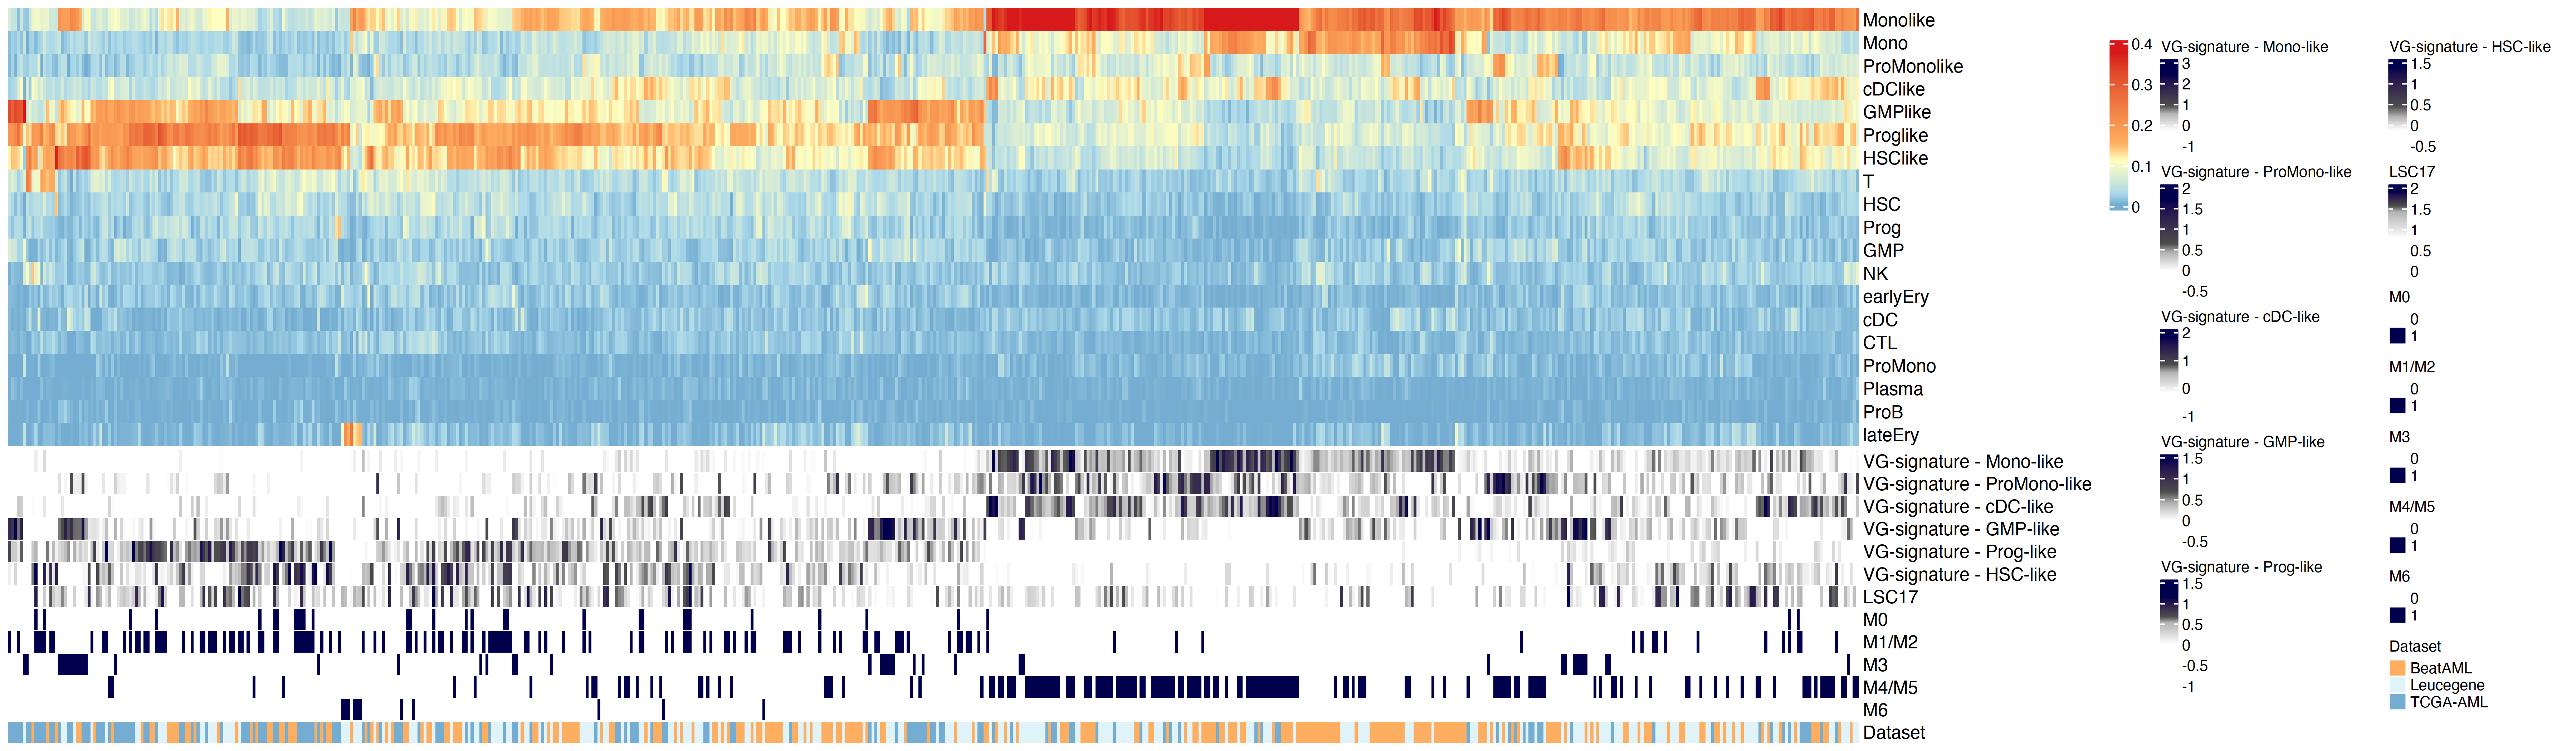

In [72]:
options(repr.plot.width = 24, repr.plot.height = 7, repr.plot.res = 300)
col_panel_vg = c("white", "white", "grey70","grey30", "#00004d")
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
p_signature = c(0.05,0.5,0.85,0.92,0.995)
col_fun = colorRamp2(num(quantile(num(as.vector(as.matrix(climb_3datasets)))[num(as.vector(as.matrix(climb_3datasets))) !=0], 
                                  p=p_signature)), col_panel)
col_fun_hsclike = colorRamp2(num(quantile(metadata$VG_HSClike, p=p_signature)), col_panel_vg)
col_fun_proglike = colorRamp2(num(quantile(metadata$VG_Proglike, p=p_signature)), col_panel_vg)
col_fun_gmplike = colorRamp2(num(quantile(metadata$VG_GMPlike, p=p_signature)), col_panel_vg)
col_fun_promonolike = colorRamp2(num(quantile(metadata$VG_ProMonolike, p=p_signature)), col_panel_vg)
col_fun_monolike = colorRamp2(num(quantile(metadata$VG_Monolike, p=p_signature)), col_panel_vg)
col_fun_cdclike = colorRamp2(num(quantile(metadata$VG_cDClike, p=p_signature)), col_panel_vg)
col_fun_lsc17 = colorRamp2(num(quantile(metadata$LSC17, p=p_signature)), col_panel_vg)
col_fun_FAB = c('0' = 'white', '1' = '#00004d')
column_ha = HeatmapAnnotation(`VG-signature - Mono-like` = metadata$VG_Monolike,
                              `VG-signature - ProMono-like` = metadata$VG_ProMonolike,
                              `VG-signature - cDC-like` = metadata$VG_cDClike,
                              `VG-signature - GMP-like` = metadata$VG_GMPlike,
                              `VG-signature - Prog-like` = metadata$VG_Proglike,
                              `VG-signature - HSC-like` = metadata$VG_HSClike,
                              `LSC17` = metadata$LSC17, 
                              `M0` = FAB_onehot$M0, `M1/M2` = ifelse(FAB_onehot$M0+FAB_onehot$M1>0, 1,0),
                              `M3` = FAB_onehot$M3, `M4/M5` = ifelse(FAB_onehot$M4+FAB_onehot$M5>0, 1,0),
                              `M6` = FAB_onehot$M6,
                              `Dataset` = metadata$dataset,
                              col = list(`VG-signature - GMP-like` = col_fun_gmplike, `VG-signature - HSC-like`=col_fun_hsclike,
                                         `VG-signature - Mono-like` = col_fun_monolike, `VG-signature - ProMono-like`=col_fun_promonolike,
                                         `VG-signature - Prog-like`=col_fun_proglike, `VG-signature - cDC-like`=col_fun_cdclike,
                                          `LSC17` = col_fun_lsc17, `Dataset` = c("BeatAML" = '#fdae61', "Leucegene" =  '#e0f3f8', "TCGA-AML" = '#74add1'),
                                         `M0` = col_fun_FAB, `M1/M2` = col_fun_FAB, `M3` = col_fun_FAB, 
                                         `M4/M5` = col_fun_FAB, `M6` = col_fun_FAB))
input_mat= t(climb_3datasets)[c('Monolike', 'Mono', 'ProMonolike','cDClike', 'GMPlike', 'Proglike', 'HSClike',
                     'T', 'HSC', 'Prog', 'GMP', 'NK', 'earlyEry', 'cDC', 'CTL', 'ProMono', 'Plasma', 'ProB', 'lateEry'),]
h = Heatmap(input_mat, show_column_names=F, show_row_dend = F, show_column_dend = F, 
        bottom_annotation = column_ha, col = col_fun, cluster_rows=F,
        #row_split = names_split,
        cluster_row_slices = FALSE, row_title_rot = 0,
        heatmap_legend_param = list(title = "",legend_height = unit(4, "cm")))
pdf('results/fig3/Heatmap_CLIMB_3datasets_withScores_final.pdf', width=22, height=7) ; h ; dev.off()
h

Let's plot also Scaden proportions :

In [100]:
climb_beataml = all_props.beataml$Scaden
climb_tcga = all_props.tcga$Scaden
climb_leucegene = all_props.leucegene$Scaden
all(colnames(climb_beataml) == colnames(climb_tcga))
all(colnames(climb_beataml) == colnames(climb_leucegene))

[1] TRUE

[1] TRUE

In [101]:
rownames(climb_leucegene) = gsub('X','',rownames(climb_leucegene))
climb_3datasets = rbind(climb_tcga, climb_leucegene, climb_beataml)
metadata = read.csv('data/aml_3cohorts/merge_metadata.csv', row.names='X')
all(rownames(climb_3datasets) == rownames(metadata))
metadata$sample_name = rownames(metadata)
FAB_onehot = dcast(data = metadata, sample_name ~ FAB, length)
FAB_onehot = FAB_onehot[match(rownames(metadata), FAB_onehot$sample_name),]

[1] TRUE

Using sample_name as value column: use value.var to override.



pdf 
  2

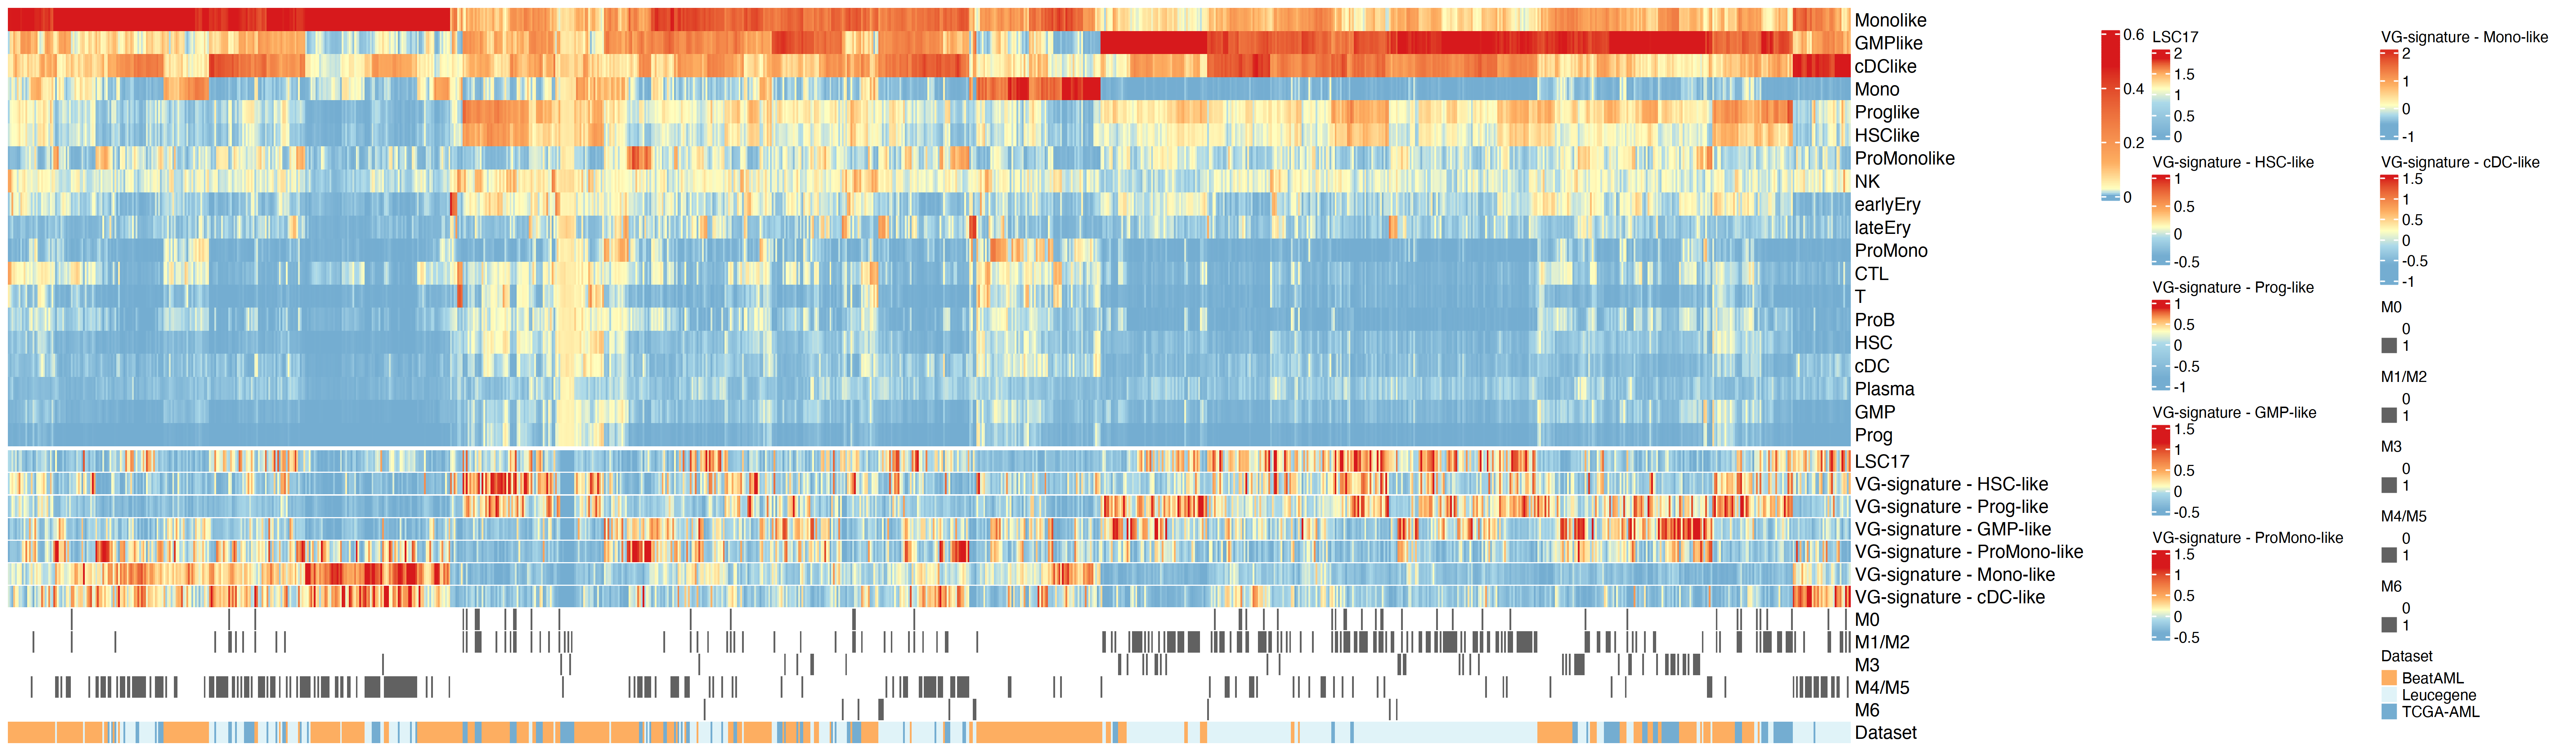

In [102]:
options(repr.plot.width = 24, repr.plot.height = 7, repr.plot.res = 300)
col_panel = c("white", "grey30", "darkred","red", "gold")
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
p_signature = c(0.05,0.5,0.7,0.88,0.98)
col_fun = colorRamp2(num(quantile(num(as.vector(as.matrix(climb_3datasets)))[num(as.vector(as.matrix(climb_3datasets))) !=0], p=p_signature)), col_panel)
col_fun_hsclike = colorRamp2(num(quantile(metadata$VG_HSClike, p=p_signature)), col_panel)
col_fun_proglike = colorRamp2(num(quantile(metadata$VG_Proglike, p=p_signature)), col_panel)
col_fun_gmplike = colorRamp2(num(quantile(metadata$VG_GMPlike, p=p_signature)), col_panel)
col_fun_promonolike = colorRamp2(num(quantile(metadata$VG_ProMonolike, p=p_signature)), col_panel)
col_fun_monolike = colorRamp2(num(quantile(metadata$VG_Monolike, p=p_signature)), col_panel)
col_fun_cdclike = colorRamp2(num(quantile(metadata$VG_cDClike, p=p_signature)), col_panel)
col_fun_lsc17 = colorRamp2(num(quantile(metadata$LSC17, p=p_signature)), col_panel)
col_fun_FAB = c('0' = 'white', '1' = 'grey38')
column_ha = HeatmapAnnotation(`LSC17` = metadata$LSC17, 
                              `VG-signature - HSC-like` = metadata$VG_HSClike,
                              `VG-signature - Prog-like` = metadata$VG_Proglike,
                              `VG-signature - GMP-like` = metadata$VG_GMPlike,
                              `VG-signature - ProMono-like` = metadata$VG_ProMonolike,
                              `VG-signature - Mono-like` = metadata$VG_Monolike,
                              `VG-signature - cDC-like` = metadata$VG_cDClike,
                              `M0` = FAB_onehot$M0, `M1/M2` = ifelse(FAB_onehot$M0+FAB_onehot$M1>0, 1,0),
                              `M3` = FAB_onehot$M3, `M4/M5` = ifelse(FAB_onehot$M4+FAB_onehot$M5>0, 1,0),
                              `M6` = FAB_onehot$M6,
                              `Dataset` = metadata$dataset,
                              col = list(`VG-signature - GMP-like` = col_fun_gmplike, `VG-signature - HSC-like`=col_fun_hsclike,
                                         `VG-signature - Mono-like` = col_fun_monolike, `VG-signature - ProMono-like`=col_fun_promonolike,
                                         `VG-signature - Prog-like`=col_fun_proglike, `VG-signature - cDC-like`=col_fun_cdclike,
                                          `LSC17` = col_fun_lsc17, `Dataset` = c("BeatAML" = '#fdae61', "Leucegene" =  '#e0f3f8', "TCGA-AML" = '#74add1'),
                                         `M0` = col_fun_FAB, `M1/M2` = col_fun_FAB, `M3` = col_fun_FAB, 
                                         `M4/M5` = col_fun_FAB, `M6` = col_fun_FAB))
h = Heatmap(t(climb_3datasets), show_column_names=F, show_row_dend = F, show_column_dend = F, 
        bottom_annotation = column_ha, col = col_fun,
        #row_split = names_split,
        cluster_row_slices = FALSE, row_title_rot = 0,
        heatmap_legend_param = list(title = "",legend_height = unit(4, "cm")))
pdf('results/fig3/Heatmap_Scaden_3datasets_withScores_2.pdf', width=22, height=7) ; h ; dev.off()
h

An interseting observation is that scaden proportions cluster much more by dataset (last line). As Scaden was run separately on each 3 dataset, we believe there is a systematic bias between Scaden's runs. Also, Scaden attribute a lot of GMP-like even though they are not labelled as 'M3' (AML subtype enriched for GMPs). Nevertheless, the FAB classification seems to cluster a bit better than for CLIMB.

In [103]:
climb_beataml = all_props.beataml$BayesPrism
climb_tcga = all_props.tcga$BayesPrism
climb_leucegene = all_props.leucegene$BayesPrism
all(colnames(climb_beataml) == colnames(climb_tcga))
all(colnames(climb_beataml) == colnames(climb_leucegene))

[1] TRUE

[1] TRUE

In [104]:
rownames(climb_leucegene) = gsub('X','',rownames(climb_leucegene))
climb_3datasets = rbind(climb_tcga, climb_leucegene, climb_beataml)
metadata = read.csv('data/aml_3cohorts/merge_metadata.csv', row.names='X')
all(rownames(climb_3datasets) == rownames(metadata))
metadata$sample_name = rownames(metadata)
FAB_onehot = dcast(data = metadata, sample_name ~ FAB, length)
FAB_onehot = FAB_onehot[match(rownames(metadata), FAB_onehot$sample_name),]

[1] TRUE

Using sample_name as value column: use value.var to override.



pdf 
  2

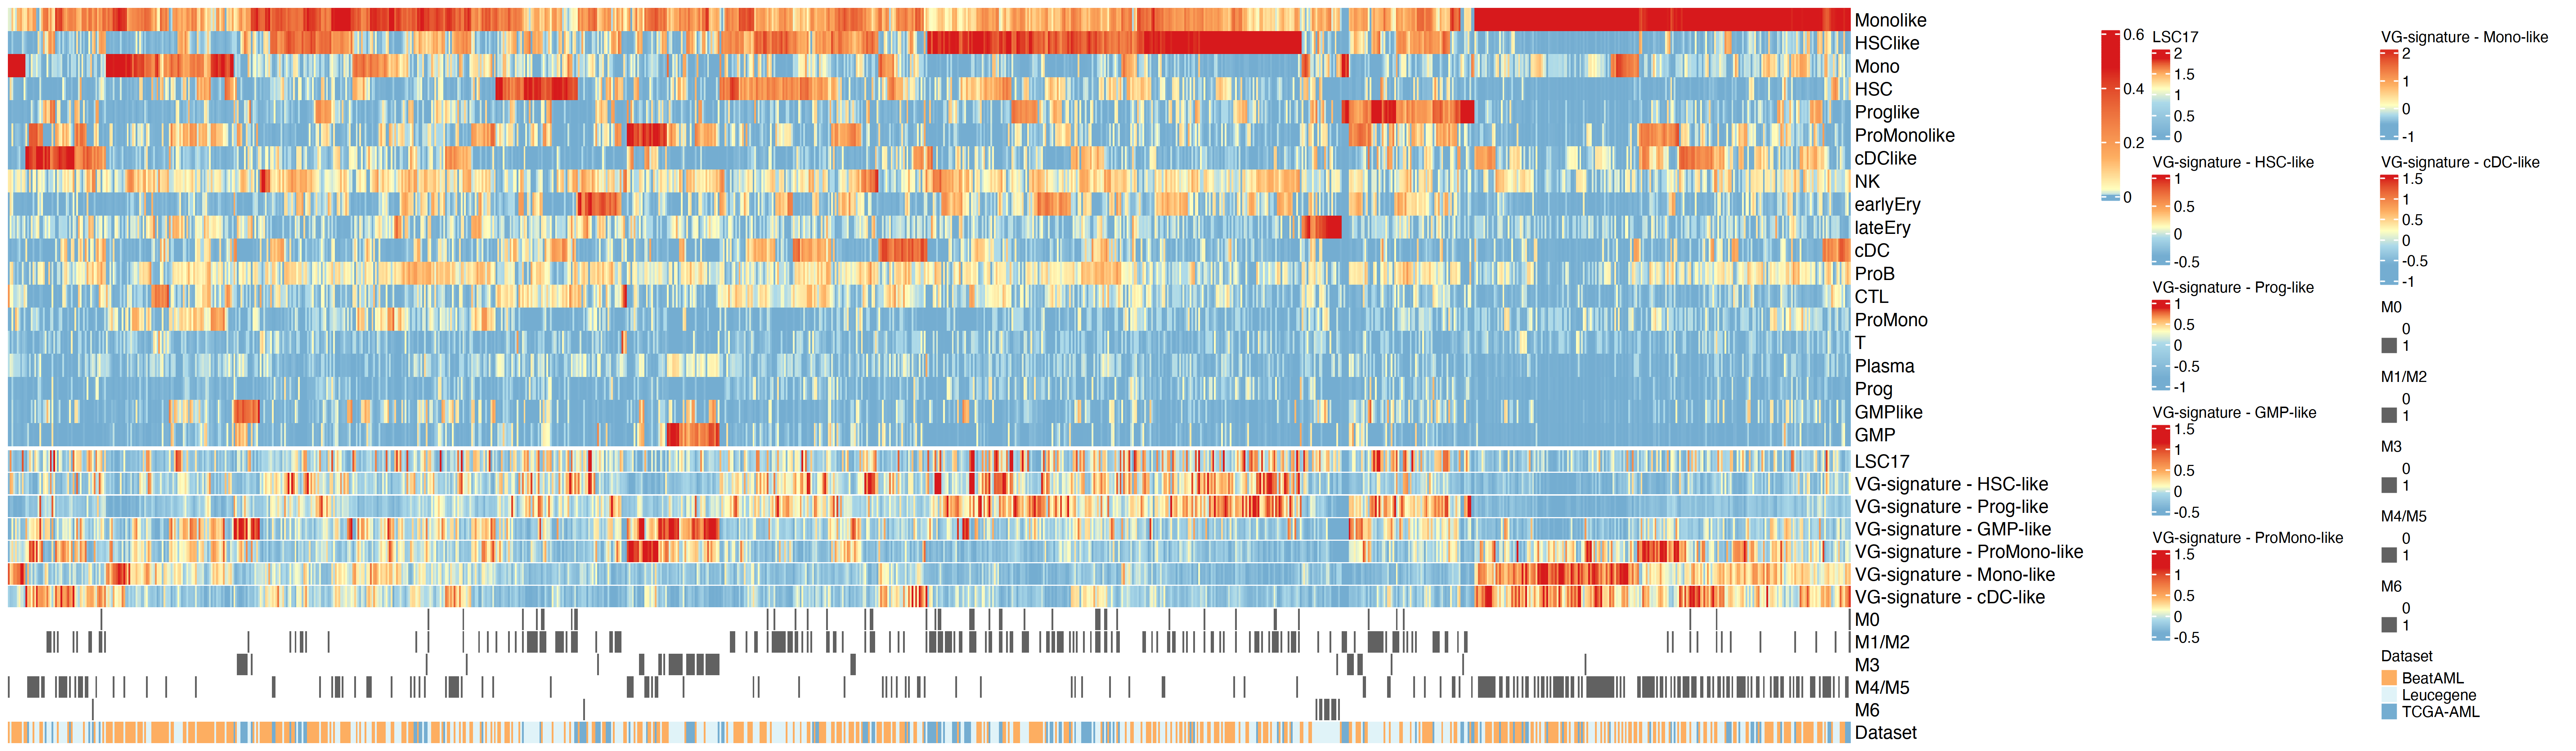

In [105]:
options(repr.plot.width = 24, repr.plot.height = 7, repr.plot.res = 300)
col_panel = c("white", "grey30", "darkred","red", "gold")
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
p_signature = c(0.05,0.5,0.7,0.88,0.98)
col_fun = colorRamp2(num(quantile(num(as.vector(as.matrix(climb_3datasets)))[num(as.vector(as.matrix(climb_3datasets))) !=0], p=p_signature)), col_panel)
col_fun_hsclike = colorRamp2(num(quantile(metadata$VG_HSClike, p=p_signature)), col_panel)
col_fun_proglike = colorRamp2(num(quantile(metadata$VG_Proglike, p=p_signature)), col_panel)
col_fun_gmplike = colorRamp2(num(quantile(metadata$VG_GMPlike, p=p_signature)), col_panel)
col_fun_promonolike = colorRamp2(num(quantile(metadata$VG_ProMonolike, p=p_signature)), col_panel)
col_fun_monolike = colorRamp2(num(quantile(metadata$VG_Monolike, p=p_signature)), col_panel)
col_fun_cdclike = colorRamp2(num(quantile(metadata$VG_cDClike, p=p_signature)), col_panel)
col_fun_lsc17 = colorRamp2(num(quantile(metadata$LSC17, p=p_signature)), col_panel)
col_fun_FAB = c('0' = 'white', '1' = 'grey38')
column_ha = HeatmapAnnotation(`LSC17` = metadata$LSC17, 
                              `VG-signature - HSC-like` = metadata$VG_HSClike,
                              `VG-signature - Prog-like` = metadata$VG_Proglike,
                              `VG-signature - GMP-like` = metadata$VG_GMPlike,
                              `VG-signature - ProMono-like` = metadata$VG_ProMonolike,
                              `VG-signature - Mono-like` = metadata$VG_Monolike,
                              `VG-signature - cDC-like` = metadata$VG_cDClike,
                              `M0` = FAB_onehot$M0, `M1/M2` = ifelse(FAB_onehot$M0+FAB_onehot$M1>0, 1,0),
                              `M3` = FAB_onehot$M3, `M4/M5` = ifelse(FAB_onehot$M4+FAB_onehot$M5>0, 1,0),
                              `M6` = FAB_onehot$M6,
                              `Dataset` = metadata$dataset,
                              col = list(`VG-signature - GMP-like` = col_fun_gmplike, `VG-signature - HSC-like`=col_fun_hsclike,
                                         `VG-signature - Mono-like` = col_fun_monolike, `VG-signature - ProMono-like`=col_fun_promonolike,
                                         `VG-signature - Prog-like`=col_fun_proglike, `VG-signature - cDC-like`=col_fun_cdclike,
                                          `LSC17` = col_fun_lsc17, `Dataset` = c("BeatAML" = '#fdae61', "Leucegene" =  '#e0f3f8', "TCGA-AML" = '#74add1'),
                                         `M0` = col_fun_FAB, `M1/M2` = col_fun_FAB, `M3` = col_fun_FAB, 
                                         `M4/M5` = col_fun_FAB, `M6` = col_fun_FAB))
h = Heatmap(t(climb_3datasets), show_column_names=F, show_row_dend = F, show_column_dend = F, 
        bottom_annotation = column_ha, col = col_fun,
        #row_split = names_split,
        cluster_row_slices = FALSE, row_title_rot = 0,
        heatmap_legend_param = list(title = "",legend_height = unit(4, "cm")))
pdf('results/fig3/Heatmap_BayesPrism_3datasets_withScores_2.pdf', width=22, height=7) ; h ; dev.off()
h